使用预训练网络有2中方法：特征提取（feature extraction）和 微调模型（fine-tuning）

## 特征提取
特征提取就是用之前网络学到的表示来从新样本中提取出有趣的特征，然后将这些特征输入一个新的分类器，从头开始训练。

用于图像分类的卷积神经网络包含2部分：一系列池化层和卷积层，最后是一个密集链接分类器。对于卷积神经网络而言，特征提取就是去除之前训练好的网络的卷积基（convolutional base），在上面运行新数据，然后在输出上训练一个新的分类器。

![img](images/005-005.png)

我们仅仅重复使用卷积基，而密集连接分类器是不能重复利用的。因为卷积基学到的表示更加通用。
- 卷积神经网络的特征图表示通用概念在图像中是否存在，无论面对什么样的计算机视觉，这种特征图都可能有用
- 分类器学到的表示必然是只针对模型训练的类别，其中仅包含某个类别出现在整张图像中的概率。另外密集连结层舍弃了空间的概念，而物体位置信息仍然由卷积特征图所描述。

In [1]:
from tensorflow.keras.applications import VGG16 # 调整过，版本问题

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

2021-12-18 22:06:17.545254: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


参数介绍：
- weights: 制定模型初始化的权重检查点
- include_top: 制定模型是否包含密集连接分类器。imageNet有1000个类别，因为我们自己做类别，所以不需要包含
- input_shape: 输入到网络中张量的形状。不传也可以，会自动适配。

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

几点说明：
1. 1792 = (3x3x3+1)x64
2. block1_conv1 (Conv2D)       (None, 150, 150, 64) , 虽然用了卷积，也进行了填充,所以不是148x148，而是150x150

接下来有2中方法可供选择：
1. 在自己的数据集上运行卷积基，将输出保存成硬盘中的Numpy 数组，然后用这个数据作为输入，输入到独立的密集连接分类器中。这种方法速度快，计算代价低。因为每个输入图像秩序运行一次卷积基。但这种方法不允许使用数据增强
2. 在顶部添加 Dense 层来罗占已有模型（即conv_base）。这种方式可以使用数据增强，但是计算代价比较高。

In [3]:
# 不使用数据增强的快速特征提取
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/ren/Desktop/data-samples/dog-and-cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


这个过程比较漫长，耐心等候，我自己电脑用时2'41''

目前，提取的特征形状为(samples,4,4,512)。我们要将其输入到密集连接分类器中，所以首先必须将其形状展平为(samples,8192)。

In [4]:
train_features=np.reshape(train_features,(2000,4*4*512))
validation_features=np.reshape(validation_features,(1000,4*4*512))
test_features=np.reshape(test_features,(1000,4*4*512))

In [5]:
# 定义密集连接分类器
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 2s 15ms/step - loss: 0.6282 - acc: 0.6415 - val_loss: 0.4428 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.4346 - acc: 0.8100 - val_loss: 0.3614 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 0.3577 - acc: 0.8435 - val_loss: 0.3241 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 0.3182 - acc: 0.8695 - val_loss: 0.2995 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2903 - acc: 0.8875 - val_loss: 0.2841 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2616 - acc: 0.8945 - val_loss: 0.2720 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2427 - acc: 0.9085 - val_loss: 0.2632 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 1s 14ms/step - 

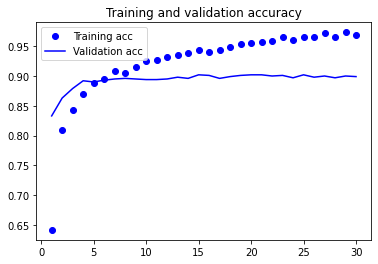

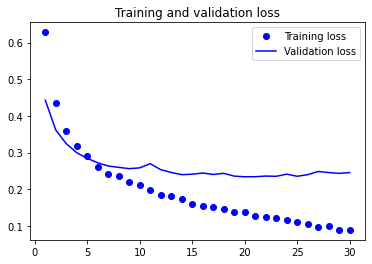

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看出，我们的验证精度都能达到95%以上，后面接近100%，比我们自己小样本训练的效果好多了。但从途中可以看出，虽然dropout比率相当大，但模型几乎从一开始就过拟合了。因为本方法没有使用数据增强，而数据增强对放置小型图像数据集的过拟合非常重要。

下面使用数据增强的特征提取。
**特别注意**：
本方法计算代价很高，只在有GPU的情况下才能尝试运行。它在CPU上是绝对难以运行的。如果你无法在GPU上运行代码，那么就采用第一种方法。

In [7]:
# 使用数据增强的特征提取
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


可以看到，在VGG16的卷积基上有1471万个参数，后面还有209万个参数，如果电脑计算，将会是非常非常恐怖的。

在训练和编译模型之前，一定要冻结卷积基。如果不这么做，那么卷积基之前学到的表示将会在训练过程中被修改。

In [9]:
conv_base.trainable = False

然后就如之前一样开始进行训练，和上节课的代码一样。因为不能在cpu上跑，我就没试验了。

## 微调模型（fine-tuning）

另一种广泛使用模型复用发发是模型微调，与特征提取互为补充。对用于特征提取的冻结模型基，微调是将顶部的几层解冻。

![img](images/005-006.png)

冻结VGG16的卷积基是为了能够在上面训练一个随机初始化的分类器。只有上面的分类器已经训练好了，才能微调卷积基的顶部几层。如果分类器没有训练好，那么训练期间通过网络传播的误差信号会特别大。所以步骤如下：
1. 在训练好的基网络商家自动以网络
2. 冻结基网络
3. 训练添加的部分
4. 解冻基网络的一些层
5. 联合训练解冻的这些层和添加的部分

为什么不微调整个卷积基？
1. 卷积基中更底层更加通用的可复用特征，而顶部的是更专业化的特征。微调这些专业话的特征更有用。微调更底部的层，回报会更少
2. 训练的参数越多，过拟合的风险越大

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
# 微调模型（fine-tuning）
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  # 特别注意，不能增强验证数据集

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')


model.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_generator,
    steps_per_epoch=30,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=14
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
30/30 [==============================] - 58s 2s/step - loss: 0.6110 - acc: 0.6740 - val_loss: 0.4838 - val_acc: 0.8103
Epoch 2/100
30/30 [==============================] - 63s 2s/step - loss: 0.4958 - acc: 0.7945 - val_loss: 0.3389 - val_acc: 0.8839
Epoch 3/100
30/30 [==============================] - 59s 2s/step - loss: 0.4244 - acc: 0.8167 - val_loss: 0.3345 - val_acc: 0.8661
Epoch 4/100
30/30 [==============================] - 58s 2s/step - loss: 0.3576 - acc: 0.8475 - val_loss: 0.2627 - val_acc: 0.8906
Epoch 5/100
30/30 [==============================] - 57s 2s/step - loss: 0.3473 - acc: 0.8400 - val_loss: 0.2454 - val_acc: 0.8996
Epoch 6/100
30/30 [==============================] - 60s 2s/step - loss: 0.3263 - acc: 0.8615 - val_loss: 0.2401 - val_acc: 0.9040
Epoch 7/100
30/30 [==============================] - 58s 2s/step - loss: 0.3141 - acc: 0.8782 - val_loss: 0.2221 - val_acc: 0.9062

In [14]:
model.save('cats_and_dogs_small_3.h5')

注意，时间特别长，我的机一共跑了107分钟。

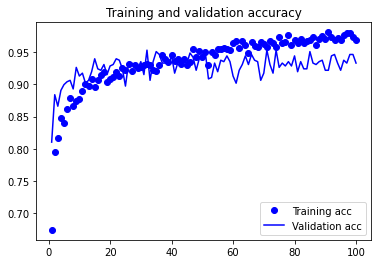

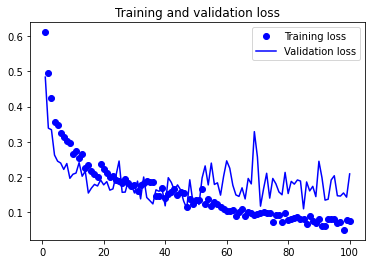

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

上面曲线比较波折，我们让曲线平滑些

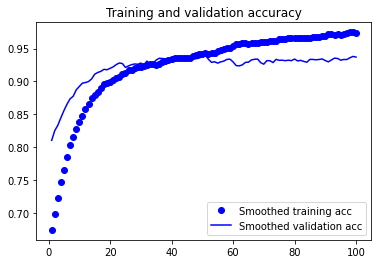

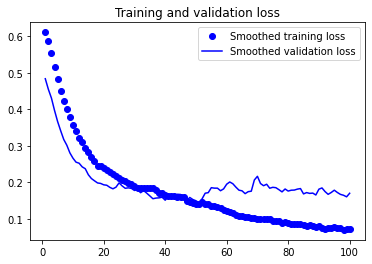

In [15]:
def smooth_curve(points,factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


- 卷积神经网络是用于计算机视觉任务的最佳学习模型。及时在非常小的数据集上也可以从头开始训练一个卷积神经网络，而且结果还不错。
- 在小型数据集上的主要问题是过拟合，在处理图像数据时，数据增强是一种降低过拟合的强大方法。
- 利用特征提取，可以很容易讲现有卷积神经网络复用与新的数据集
- 作为特征提取的补充，你还可以微调，进一步提高模型性能。